In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple

In [2]:
## Self explanatory
save_plots = False

# A look at the PDF

In [3]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [4]:
## in eV
m_electron = 0.511e6
m_lambda = 1116e6

## in eV/T
bohr_magneton = 5.788e-5

## in eV s
hbar = 6.582e-16

## in m/s
c = 299792458.

In [5]:
hbar * c

1.973233958556e-07

In [6]:
## Assuming EDM is 0
def particle_magneton(m_particle):
    return bohr_magneton * m_electron / m_lambda

def phi_rot(g: float, Dy: float, beta: float, m_particle: float):
    muB = particle_magneton(m_particle)
    return g * Dy * muB / (beta * hbar * c)

In [7]:
def pdf(theta, phi, sz=1, g=1.226, Dy=4, beta=1.):
    alpha = 0.642
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    
    s = np.array([
        - sz * np.sin(Phi_rot),
        0,
        sz * np.cos(Phi_rot)
    ])
    
    k_hat = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])
    
    return 1 + alpha * scalar_product(s, k_hat)

In [8]:
theta_min = 0
theta_max = 2*np.pi
phi_min = -np.pi
phi_max = np.pi

bins = 100

theta_list = np.linspace(theta_min, theta_max, bins)
phi_list = np.linspace(phi_min, phi_max, bins)

theta_grid, phi_grid = np.meshgrid(theta_list, phi_list)
ys = pdf(theta_grid, phi_grid)

In [9]:
ys.min()

0.3580192540175796

In [10]:
ys.max()

1.641815290374288

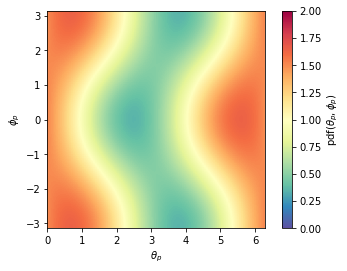

In [11]:
plt.imshow(ys,extent=[theta_min, theta_max,phi_min, phi_max], cmap='Spectral_r', origin='lower')
plt.clim(0,2)
plt.colorbar(label=r"$\mathrm{pdf}(\theta_p,\phi_p)$")
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

# Event generation

In [12]:
class Generator:
    
    def __init__(self,
        event_number: int, 
        random_state: int = 2022
    ):
        self._event_number = event_number
        self._random_state = random_state
        random.seed(random_state)
    
    ## Getter and setter methods
    @property
    def event_number(self) -> int:
        return self._event_number
    
    @event_number.setter
    def event_number(self, n) -> None:
        self._event_number = n
    
    @property
    def random_state(self) -> int:
        return self._random_state
    
    @random_state.setter
    def random_state(self, n) -> None:
        self._random_state = n
        random.seed(n)
        
    ## Individual generators
    def generate_omega(self) -> Tuple[float]:
        pdf_min = 0
        pdf_max = 2
                
        accept = False
        while accept is not True:
            theta = random.uniform(0,2*np.pi)
            phi = random.uniform(-np.pi,np.pi)
            yref = random.uniform(pdf_min, pdf_max)
            
            if yref <= pdf(theta, phi):
                accept = True
        
        return theta, phi
    
    ## For now it's very simplified: lambda momentum along z, maximal polarization s0 = 1, g=1.226, Dy = 4 T m, beta= 1
    def generate_event(self) -> dict:
        own_vertex = [0,0, random.uniform(0,1000)]
        momentum = [0,0,random.uniform(0,10000)]
        decay_length = random.uniform(0,5000)
        
        end_vertex = [
            random.uniform(-1000,1000),
            random.uniform(-1000,1000),
            random.uniform(5500,8500)
        ]
        
        theta, phi = self.generate_omega()
        
        event_dict = {
            'L_OWNVERTEX_X': own_vertex[0],
            'L_OWNVERTEX_Y': own_vertex[1],
            'L_OWNVERTEX_Z': own_vertex[2],
            'L_PX': momentum[0],
            'L_PY': momentum[1],
            'L_PZ': momentum[2],
            'L_DECAYLENGTH': decay_length,
            'L_ENDVERTEX_X': end_vertex[0],
            'L_ENDVERTEX_Y': end_vertex[1],
            'L_ENDVERTEX_Z': end_vertex[2],
            'THETA': theta,
            'PHI': phi
        }
        
        return event_dict
    
    def generate_sample(self) -> pd.DataFrame:
        events = []
        
        for i in range(self._event_number):
            events.append(self.generate_event())
        
        df = pd.DataFrame(events)
        
        return df

In [13]:
pseudo_experiment_generator = Generator(100000, random_state=2022)
df_generated = pseudo_experiment_generator.generate_sample()
df_generated

,L_OWNVERTEX_X,L_OWNVERTEX_Y,L_OWNVERTEX_Z,L_PX,L_PY,L_PZ,L_DECAYLENGTH,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,THETA,PHI
0,0,0,531.625750,0,0,4426.059615,1550.267845,-878.420301,567.250664,8446.083256,5.410340,1.639915
1,0,0,625.235390,0,0,5496.473299,2597.707084,-924.005809,490.051463,6294.857689,5.690371,2.360895
2,0,0,405.513063,0,0,667.783464,2085.054750,-117.071268,-972.037940,6187.546745,3.035248,-2.700948
3,0,0,106.303629,0,0,3897.213163,4985.154400,-447.161407,-937.112632,8454.025854,3.972535,-0.396537
4,0,0,941.928290,0,0,4320.620606,139.466811,487.837479,-157.184259,7537.396420,4.394827,-1.117518
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,111.815364,0,0,2436.366223,2269.652634,-503.412411,-82.673945,8190.053132,5.935210,2.496201
99996,0,0,37.098507,0,0,9916.180790,293.691649,810.649066,-754.312020,7692.770183,1.882071,-0.693536
99997,0,0,713.938020,0,0,4376.358426,1831.723622,215.904580,-404.612087,7224.296332,5.441848,-1.079581
99998,0,0,803.105053,0,0,9282.717716,4333.335417,831.551842,-81.647947,7140.988457,5.295381,1.391060


# Analysis of generated events

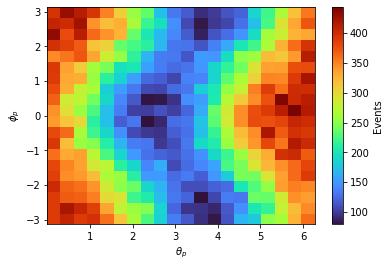

In [14]:
plt.hist2d(df_generated['THETA'], df_generated['PHI'], cmap='turbo', bins=20)
plt.colorbar(label='Events')
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

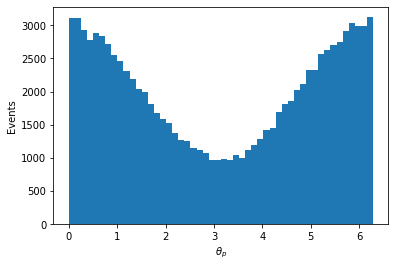

In [15]:
plt.hist(df_generated['THETA'],bins=50)
plt.xlabel(r"$\theta_p$")
plt.ylabel("Events")
plt.show()

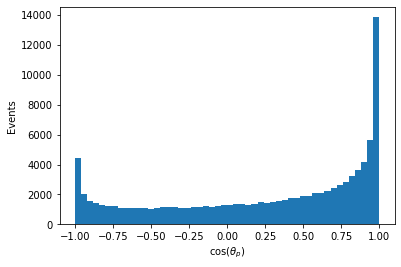

In [16]:
plt.hist(np.cos(df_generated['THETA']),bins=50)
plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel("Events")
plt.show()

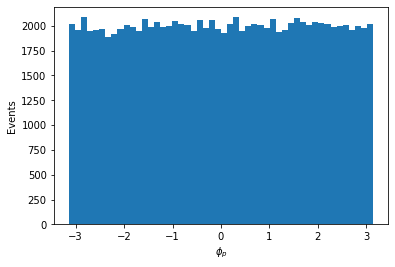

In [17]:
plt.hist(df_generated['PHI'],bins=50)
plt.xlabel(r"$\phi_p$")
plt.ylabel("Events")
plt.show()

# Fit of events